In [8]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

from AdaBins import model_io
from AdaBins.models import UnetAdaptiveBins

MIN_DEPTH = 1e-3
MAX_DEPTH_NYU = 10
MAX_DEPTH_KITTI = 80

N_BINS = 256

PRETRAINED_PATH_NYU = "./weights/AdaBins_nyu.pt"
PRETRAINED_PATH_KITTI = "./weights/AdaBins_kitti.pt"

In [2]:
def load_image(image_path):
    image = Image.open(image_path)
    image = np.array(image).astype(np.float32) / 255.0
    image = torch.Tensor(image).permute(2, 0, 1).unsqueeze(0)
    return image

In [3]:
def output2depth(output):
    return output.squeeze().detach().numpy()

### KITTI-Depth

In [4]:
model = UnetAdaptiveBins.build(n_bins=N_BINS, min_val=MIN_DEPTH, max_val=MAX_DEPTH_KITTI)

model, _, _ = model_io.load_checkpoint(PRETRAINED_PATH_KITTI, model)

Loading base model ()...

/Users/lucamagri/miniconda3/envs/DNN3D/lib/python3.11/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /Users/lucamagri/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ap-9e82fae8.pth" to /Users/lucamagri/.cache/torch/hub/checkpoints/tf_efficientne

Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..

/Users/lucamagri/miniconda3/envs/DNN3D/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Done.


In [5]:
image = load_image("./data/kitti-depth/01.png")
_, output = model(image)

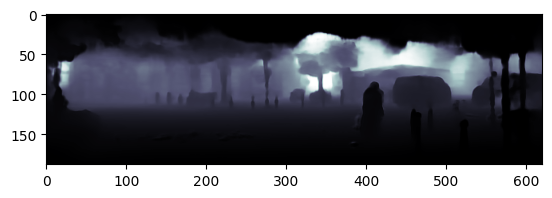

In [6]:
depth = output2depth(output)
_ = plt.imshow(depth, cmap="bone")

Let's compute a very simple confidence measure

In [10]:
horizontal_flip = T.RandomHorizontalFlip(p = 1.0)
hflipped_image = horizontal_flip(image)
_, output_flipped = model(hflipped_image)
depth_flipped = output2depth(output_flipped)

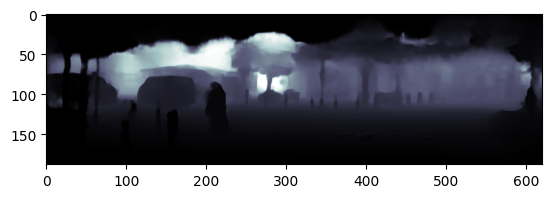

In [12]:
_ = plt.imshow(depth_flipped, cmap="bone")

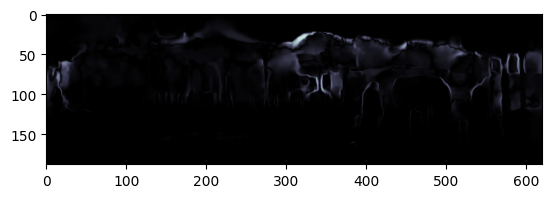

In [14]:
output_reflipped = horizontal_flip(output_flipped)
depth_reflipped = output2depth(output_reflipped)
_ = plt.imshow(np.abs(depth - depth_reflipped), cmap="bone")

The higher error is along image borders.

### NYU

Loading base model ()...

Using cache found in /Users/lucamagri/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..

/Users/lucamagri/miniconda3/envs/DNN3D/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Done.


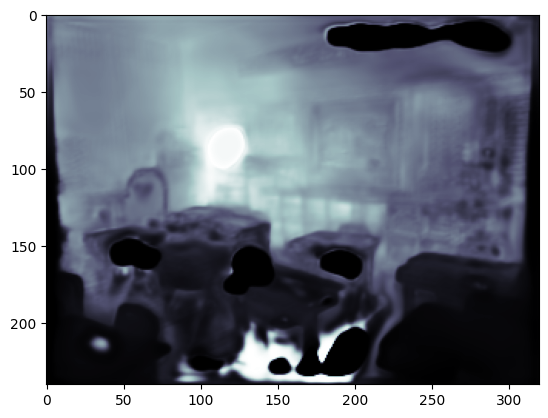

In [15]:
model = UnetAdaptiveBins.build(n_bins=N_BINS, min_val=MIN_DEPTH, max_val=MAX_DEPTH_NYU)
model, _, _ = model_io.load_checkpoint(PRETRAINED_PATH_NYU, model)

image = load_image("./data/nyu/01.jpg")
_, output = model(image)
depth = output2depth(output)

_ = plt.imshow(depth, cmap="bone")

## Generalization across different domains

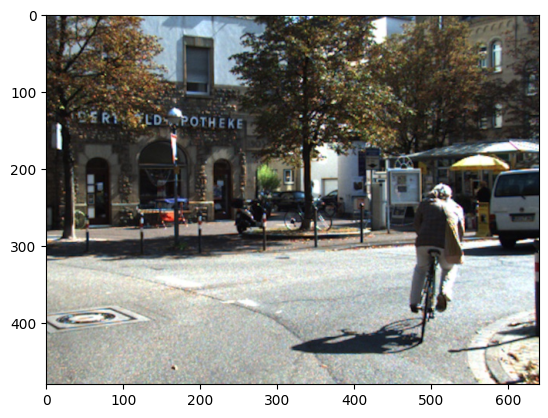

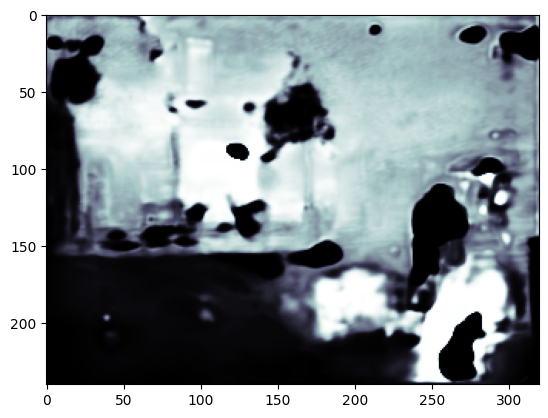

In [21]:

image = load_image("./data/kitti-depth/01cropped.jpg")
_, output = model(image)
depth = output2depth(output)
_ = plt.imshow(image.detach().squeeze().permute(1, 2, 0).numpy())
plt.show()
_ = plt.imshow(depth, cmap="bone")